# Single Label Classification with Computer Vision (Beginner)
> Covering how to perform single-label classification with the PETs dataset

In [4]:
!pip install wwf nbdev

     |████████████████████████████████| 46 kB 1.7 MB/s 
     |████████████████████████████████| 51 kB 241 kB/s 


In [5]:
#hide
from wwf.utils import *
from nbdev.showdoc import *

In [ ]:
#hide_input
state_versions(['fastai', 'fastcore'])

---
This article is also a Jupyter Notebook available to be run from the top down. There will be code snippets that you can then run in any environment. Below are the versions of `fastai` and `fastcore` currently running at the time of writing this:
* `fastai`: 2.0.14 
* `fastcore`: 1.0.11 
---

## Introduction

This tutorial will cover single-label classification inside of the `fastai` library. It will closely follow the lesson 1 notebook from [A walk with fastai2](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Pets.ipynb) and if you wish to watch the lecture video it is available [here](https://www.youtube.com/watch?v=bw4PRyxa-y4&list=PLFDkaGxp5BXDvj3oHoKDgEcH73Aze-eET&index=1&t=4340s)

## Importing the Library and the Dataset

First we need to import `fastai`'s `vision` module:

In [ ]:
from fastai.vision.all import *

The `PETs` dataset is designed to try and distinguish between 12 species of cats and 25 species of dogs (37 in total). Five years ago the best accuracy was 59% with seperate classifications for parts of the images cropped to related body parts (the head, body, and overall image). Today's neural networks can perform much better on a task such as this, so we will try to achieve a better result using only the one image.

But before anything, we need data!

To do so we will use the `untar_data` function paired with `URLs.PETS`. This will go ahead and download and extract a `.gz` dataset for us. The `URLs.PETS` denotes the URL where our dataset lives.

We can view the documentation for `untar_data` by using the `help` or `doc` functions:

In [ ]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function file_extract at 0x7fe4f0427050>)
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`.



`doc` will pull it up in a pop-up window (run this notebook to see):

In [ ]:
doc(untar_data)

Along with this if we want to explore the source code for any function, put two `??` after the name of the function and a popup window will appear with the source code!

In [ ]:
untar_data??

Now let's download our dataset:

In [ ]:
path = untar_data(URLs.PETS)

We can see the location of where our data was stored by checking what `path` contains:

In [ ]:
path

Path('/home/ml1/.fastai/data/oxford-iiit-pet')

To make this notebook reproduceable, we can use `fastai`'s `set_seed` function to ensure every possible source of randomness has the same seed:

In [ ]:
set_seed(2)

Now let's look at hour our data was stored:

In [ ]:
path.ls()[:3]

(#2) [Path('/home/ml1/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/ml1/.fastai/data/oxford-iiit-pet/images')]

We can see a `images` and `annotations` folder. We'll focus on the `images` folder.

## Building the `DataLoaders`

To actually train our neural network model we need to first prepare our dataset for `fastai` to expect it. This comes in the form of `DataLoaders`. We'll show a high-level one-liner usage followed by a `DataBlock` example

Since we have the `path` to our data, we'll need to extract the filenames of all the images. 

`get_image_files` can do this for us, we simply pass in our `path` to where the images are stored: 

In [ ]:
fnames = get_image_files(path/'images')

Now if we look at a filename, we will see that the filename itself contains our class label. We can use a Regular Expression to extract it. 
> Do note: throughout this resource you will find multiple ways of completing the same task, so you do not have to follow this example to the letter

In [ ]:
pat = r'/([^/]+)_\d+.*'

With our pattern that can extract our label, let's move onto some basic transforms:

In [ ]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

> We intend to use a pretrained model for our task, so we need to normalize our data by the original model's data's statistics

Along with how many images we want our model to process at one time (a batch size):

In [ ]:
bs=64

Lastly we can build our `DataLoaders`! Let's see a one-liner where we pass it all in
> For those familiar with `fastai` v1, this is akin to `ImageDataBunch`

In [ ]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, 
                                   batch_tfms=batch_tfms,
                                   item_tfms=item_tfms, bs=bs)

What about using the `DataBlock` API I keep hearing about? 

It's a way to formulate a *blueprint* of a data pipeline that can be tweaked more than the factory `xDataLoaders` methods. The version for our problem looks like:

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2),
                 get_y=RegexLabeller(pat = pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

Let's break it all down:
  * `blocks`: 
    * `ImageBlock`: Our `x`'s will be images
    * `CategoryBlock`: Our `y`s will be a single category label
  * `get_items`: How we are getting our data. (when doing image problems you will mostly just use `get_image_files` by default)
  * `splitter`: How we want to split our data. 
    * `RandomSplitter`: Will randomly split the data with 20% in our validation set (by default), with the other 80% in our training data. We can pass in a percentage and a seed. (we won't be doing the latter as we already set a global seed)
  * `get_y`: How to extract the labels for our data
    * `RegexLabeller`: Uses a Regex `pat` to extract them
  * `item` and `batch` tfms are our data augmentation

So now that we have the blueprint we can build our `DataLoaders` by calling the `.dataloaders` method. We'll need to pass it a location to find our source images as well as that batch size we defined earlier:

In [ ]:
path_im = path/'images'
dls = pets.dataloaders(path_im, bs=bs)

## Looking at the Data

Now that the `DataLoaders` have been built we can take a peek at the data and a few special bits and pieces about them. 

First let's take a look at a batch of data. We can use the `show_batch` function and pass in a maximum number of images to show, as well as how large we want them to appear as in our notebooks. 
> By default it will show images from the validation `DataLoader`. To show data from the training set, use `dls[0]` rather than `dls`

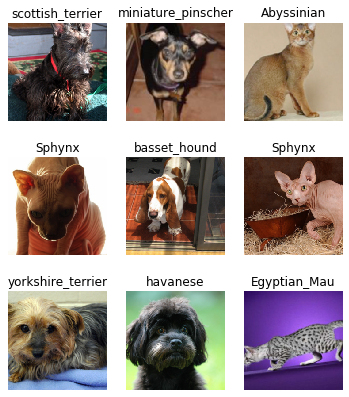

In [ ]:
dls.show_batch(max_n=9, figsize=(6,7))

If we want to see how many classes we have, and the names of them we can simply call `dls.vocab`. The first is the number of classes, the second is the names of our classes. You may notice this looks a bit odd, that's because this `L` is a new invention of Jeremy and Sylvian. Essentially it's a Python list taken to the extreme.

Before if we wanted to grab the index for the name of a class (eg. our model output 0 as our class), we would need to use `data.c2i` to grab the Class2Index mapping. This is still here, it lives in `dls.vocab.o2i` (Object2ID).

It's a dictionary mapping of `name -> value`, so let's only look at the first five (since we have 37 in total!)

In [ ]:
{k: dls.vocab.o2i[k] for k in list(dls.vocab.o2i)[:5]}

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4}

## Time To Make and Train a Model!

We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier. Don't worry if thats a bunch of nonsense for now. Right now, just know this: we are piggybacking off of a model to help us classify images into 37 categories.

First we need to make our neural network using a `Learner`. A `Learner` needs (on a basic level):
* `DataLoaders`
* An architecture
* An evaluation metric (not actually required for training)
* A loss function
* An optimizer

We'll also be using `mixed_precision` (fp16).

There are many different `Learner` cookie-cutters to use based on what problem you are using it for. Since we're doing transfer learning with CNN's, we will use `cnn_learner` and a ResNet34:

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

Some assumptions and magic is being done here:
* Loss function is assumed as classification (from the `DataLoaders`), so `CrossEntropyLossFlat` is being used
* By default the optimizer is Adam
* A custom head was added onto our ResNet body, with the body's weights being frozen

Now we can train it! We will train for one cycle through all our data:

In [ ]:
learn.fit_one_cycle(1)

Afterwards we can *unfreeze* those frozen weights and train a little more. We'll utilize the `Learner.lr_find` function to help us decide a good learning rate: 

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=1.9054607491852948e-06)

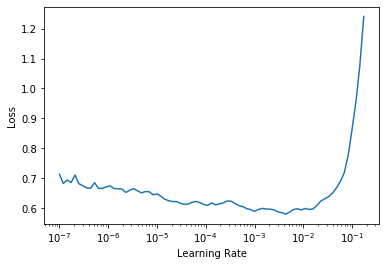

In [ ]:
learn.lr_find()

Alright so if we look here, we don't really start seeing a spike in our losses until we get close to 1e-2, so a good section to train on is between 1e-4 and 1e-3, so we'll do that!

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-4, 1e-3))

And now we have a fully trained model! At the start we set a goal: to beat 59% accuracy usin gonly the image inputs. 

We more than succeeded, achieving 94% accuracy while training for only five epochs!

To use such a model in production, examples of `learn.predict` and `learn.get_preds` with `test_dl` are shown below:

In [ ]:
clas, clas_idx, probs = learn.predict(fnames[0]); clas

'Birman'

In [ ]:
test_dl = learn.dls.test_dl(fnames[:10])
preds = learn.get_preds(dl=test_dl)

To get the class names decoded we can do the following:

In [ ]:
class_idxs = preds[0].argmax(dim=0)
res = [dls.vocab[c] for c in class_idxs]

In [ ]:
res[:10]

['Russian_Blue',
 'Bombay',
 'Abyssinian',
 'Persian',
 'Egyptian_Mau',
 'Russian_Blue',
 'Russian_Blue',
 'Bengal',
 'Abyssinian',
 'Egyptian_Mau']